In [1]:
import pandas as pd
import json
import csv
import re

from nltk.corpus import stopwords
import nltk


from fasttext import load_model
from huggingface_hub import hf_hub_download

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns



/home/julian/info/Uni/thesis/toxic-bert/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
input_json = "/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-klueber/instances/instances_data.json"
output_csv = "instances.csv"

instances = []

with open(input_json, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            instance_data = json.loads(line)
            instance_name = instance_data["instance"]
            rules = instance_data["rules"]
            
            if rules is None or rules == []:
                instances.append({"instance": instance_name, "rules": ""})
            else:
                rules_str = " | ".join(rule["text"] for rule in rules) if isinstance(rules, list) else str(rules)
                instances.append({"instance": instance_name, "rules": rules_str.replace("\n", "")})

headers = ['instance', 'rules']

with open(output_csv, 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=headers)
    writer.writeheader()
    writer.writerows(instances)

In [2]:
input_csv = "instances.csv"

df = pd.read_csv(input_csv, dtype=str)

with open('instances.txt', 'r') as f:
    txt_instances = set(line.strip() for line in f if line.strip())

df = df[df['instance'].isin(txt_instances)]

df_with_rules = df[df["rules"].notna() & (df["rules"].str.strip() != "")]
df_without_rules = df[df["rules"].isna() | (df["rules"].str.strip() == "")]

In [3]:
model_path = hf_hub_download(
    repo_id="facebook/fasttext-language-identification",
    cache_dir="/tmp/fasttext",
    filename="model.bin",
)

lang_detector = load_model(model_path)

In [4]:
df_with_rules["language"] = df_with_rules["rules"].apply(lambda x: lang_detector.predict(x)[0][0])
df_english = df_with_rules[df_with_rules["language"] == "__label__eng_Latn"]

/tmp/ipykernel_1421239/1164856214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_rules["language"] = df_with_rules["rules"].apply(lambda x: lang_detector.predict(x)[0][0])


In [5]:
df_english.to_csv('df_english.csv', index=False)

In [6]:
df_english = df_english.groupby('rules').agg(list).reset_index()

In [7]:
df_english

,rules,instance,language
0,"No racism, sexism, homophobia, transphobia...",[ellis.social],[__label__eng_Latn]
1,Be friendly and respectful to all members - N...,[gamedev.lgbt],[__label__eng_Latn]
2,"No automated cross posting from Twitter, RSS,...",[mastodon.nzoss.nz],[__label__eng_Latn]
3,"No hate speech or bigotry, including but not ...",[socialclub.nyc],[__label__eng_Latn]
4,Sexually explicit or violent media must be ma...,[technodon.org],[__label__eng_Latn]
...,...,...,...
512,no bigotry (should be obvious) | please genera...,[fedi.halcyon-is.land],[__label__eng_Latn]
513,严禁发布任何形式的儿童色情及恐怖主义内容，一经发现立即永久封禁。\rThe distribu...,[social.kryta.app],[__label__eng_Latn]
514,你發佈的內容屬於你，你需要為它們負責。\rYou own what you post and...,[mastodon.hk],[__label__eng_Latn]
515,拒绝真人不雅内容 / No inappropriate real-life content....,[wxw.moe],[__label__eng_Latn]


In [8]:
print(df.shape[0])
print(df_without_rules.shape[0])
print(df_with_rules.shape[0])
print(df_english.shape[0])

963
115
848
517


In [9]:
df_english["sentence_length"] = df_english["rules"].apply(lambda x: len(x.split()))

df_english["length_category"] = pd.cut(df_english["sentence_length"], 
                               bins=[0, 10, 100, df_english["sentence_length"].max()], 
                               labels=["Short", "Medium", "Long"])

df_sorted = df_english.sort_values(by="sentence_length", ascending=True)

df_sorted[["rules", "sentence_length", "length_category"]]


,rules,sentence_length,length_category
199,Follow the money.,3,Short
161,Don't be a dick,4,Short
509,don't do stupid shit,4,Short
158,Don't be a butthead.,4,Short
39,Be a good person.,4,Short
...,...,...,...
120,"By being here, you agree to follow the Julia L...",443,Long
60,Be good and kind to each other.\rGive people's...,454,Long
149,"Do not use slurs or racist, sexist, homophobic...",461,Long
257,No discrimination or hateful ideals. This incl...,465,Long


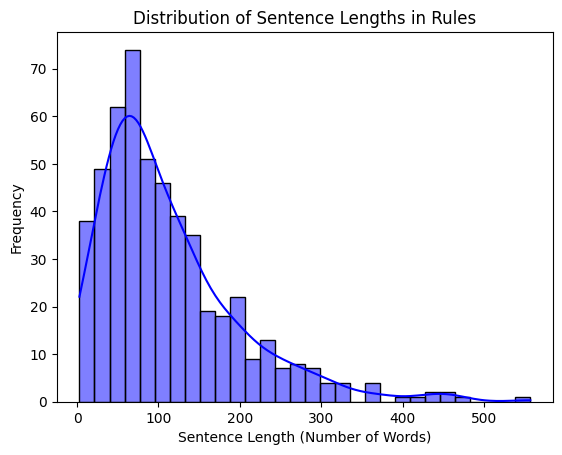

/tmp/ipykernel_1421239/525967548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="length_category", data=df_english, palette="coolwarm")


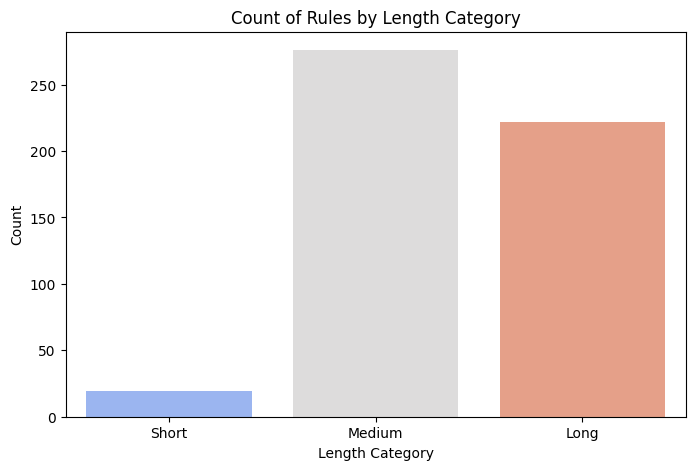

In [10]:
sns.histplot(df_english["sentence_length"], bins=30, kde=True, color="blue")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths in Rules")
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x="length_category", data=df_english, palette="coolwarm")
plt.xlabel("Length Category")
plt.ylabel("Count")
plt.title("Count of Rules by Length Category")
plt.show()

In [13]:
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# # remove stopwords
# for rules in df_english["rules"]:
#     words = re.findall(r"\w+", rules.lower()) 
#     filtered_words = [word for word in words if word not in stop_words]
#     df_english["rules"] = df_english["rules"].replace(rules, " ".join(filtered_words))


[nltk_data] Downloading package stopwords to /home/julian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
categories = {
    "Speech & Expression Rights": [
        "free speech", "expression", "censorship", "opinion", "discourse", 
        "democracy", "dissent", "dialogue", "advocacy", "viewpoint"
    ],
    
    "User Safety & Protection": [
        "harassment", "abuse", "threat", "harm", "safety", "protection",
        "vulnerability", "support", "intervention", "reporting"
    ],
    
    "Discrimination & Hate": [
        "hate speech", "bias", "discrimination", "prejudice", "stereotype",
        "exclusion", "marginalization", "extremism", "targeting", "slurs"
    ],
    
    "Content Classification": [
        "explicit", "graphic", "adult", "sensitive", "age-restricted",
        "violence", "disturbing", "inappropriate", "restricted", "mature"
    ],
    
    "Community Standards": [
        "civility", "respect", "conduct", "behavior", "guidelines",
        "etiquette", "norms", "standards", "interaction", "engagement"
    ],
    
    "Platform Integrity": [
        "spam", "manipulation", "automation", "authenticity", "quality",
        "artificial", "deception", "reliability", "verification", "trust"
    ],
    
    "Legal Compliance": [
        "regulation", "compliance", "copyright", "liability", "jurisdiction",
        "legislation", "enforcement", "policy", "terms", "guidelines"
    ],
    
    "Data Privacy & Security": [
        "privacy", "confidentiality", "consent", "disclosure", "protection",
        "security", "identification", "anonymity", "encryption", "safeguards"
    ]
}

# References used for this categorization:
"""
1. Gillespie, T. (2018). Custodians of the Internet: Platforms, content moderation, and the hidden decisions that shape social media
2. Roberts, S. T. (2019). Behind the Screen: Content Moderation in the Shadows of Social Media
3. Gorwa, R., Binns, R., & Katzenbach, C. (2020). Algorithmic content moderation: Technical and political challenges in the automation of platform governance
4. Suzor, N. (2019). Lawless: The secret rules that govern our digital lives
5. Cambridge Consultants. (2019). Use of AI in Online Content Moderation
6. Santa Clara Principles on Transparency and Accountability in Content Moderation
7. Article 19's Principles on Content Moderation
"""

def categorize_rule(rule):
    matched_categories = [category for category, keywords in categories.items() if any(word in rule.lower() for word in keywords)]
    return ", ".join(matched_categories) if matched_categories else "Other"

df_english["category"] = df_english["rules"].apply(categorize_rule)

df_english[["category"]]

,category
0,"User Safety & Protection, Discrimination & Hat..."
1,"User Safety & Protection, Community Standards"
2,"User Safety & Protection, Discrimination & Hat..."
3,"User Safety & Protection, Discrimination & Hat..."
4,"User Safety & Protection, Content Classification"
...,...
512,Content Classification
513,"User Safety & Protection, Platform Integrity, ..."
514,User Safety & Protection
515,"Content Classification, Community Standards, P..."


/tmp/ipykernel_1421239/272377382.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


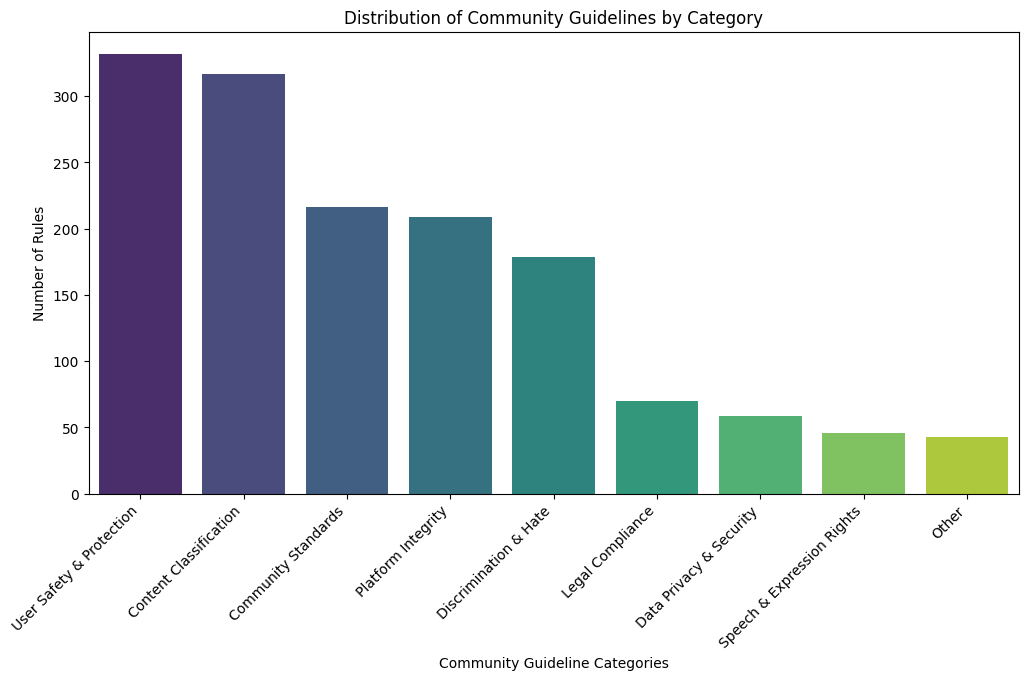

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

category_counts = df_english["category"].str.split(", ").explode().value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Community Guideline Categories")
plt.ylabel("Number of Rules")
plt.title("Distribution of Community Guidelines by Category")
plt.show()



Category Frequencies:
User Safety & Protection: 332 rules
Content Classification: 317 rules
Community Standards: 216 rules
Platform Integrity: 209 rules
Discrimination & Hate: 179 rules
Legal Compliance: 70 rules
Data Privacy & Security: 59 rules
Speech & Expression Rights: 46 rules

Top Co-occurrences:
User Safety & Protection × Content Classification: 251 rules
User Safety & Protection × Platform Integrity: 158 rules
Content Classification × Platform Integrity: 154 rules
Community Standards × Content Classification: 136 rules
User Safety & Protection × Community Standards: 133 rules
User Safety & Protection × Discrimination & Hate: 125 rules
Content Classification × Discrimination & Hate: 122 rules
Community Standards × Platform Integrity: 105 rules
Discrimination & Hate × Platform Integrity: 99 rules
Community Standards × Discrimination & Hate: 89 rules


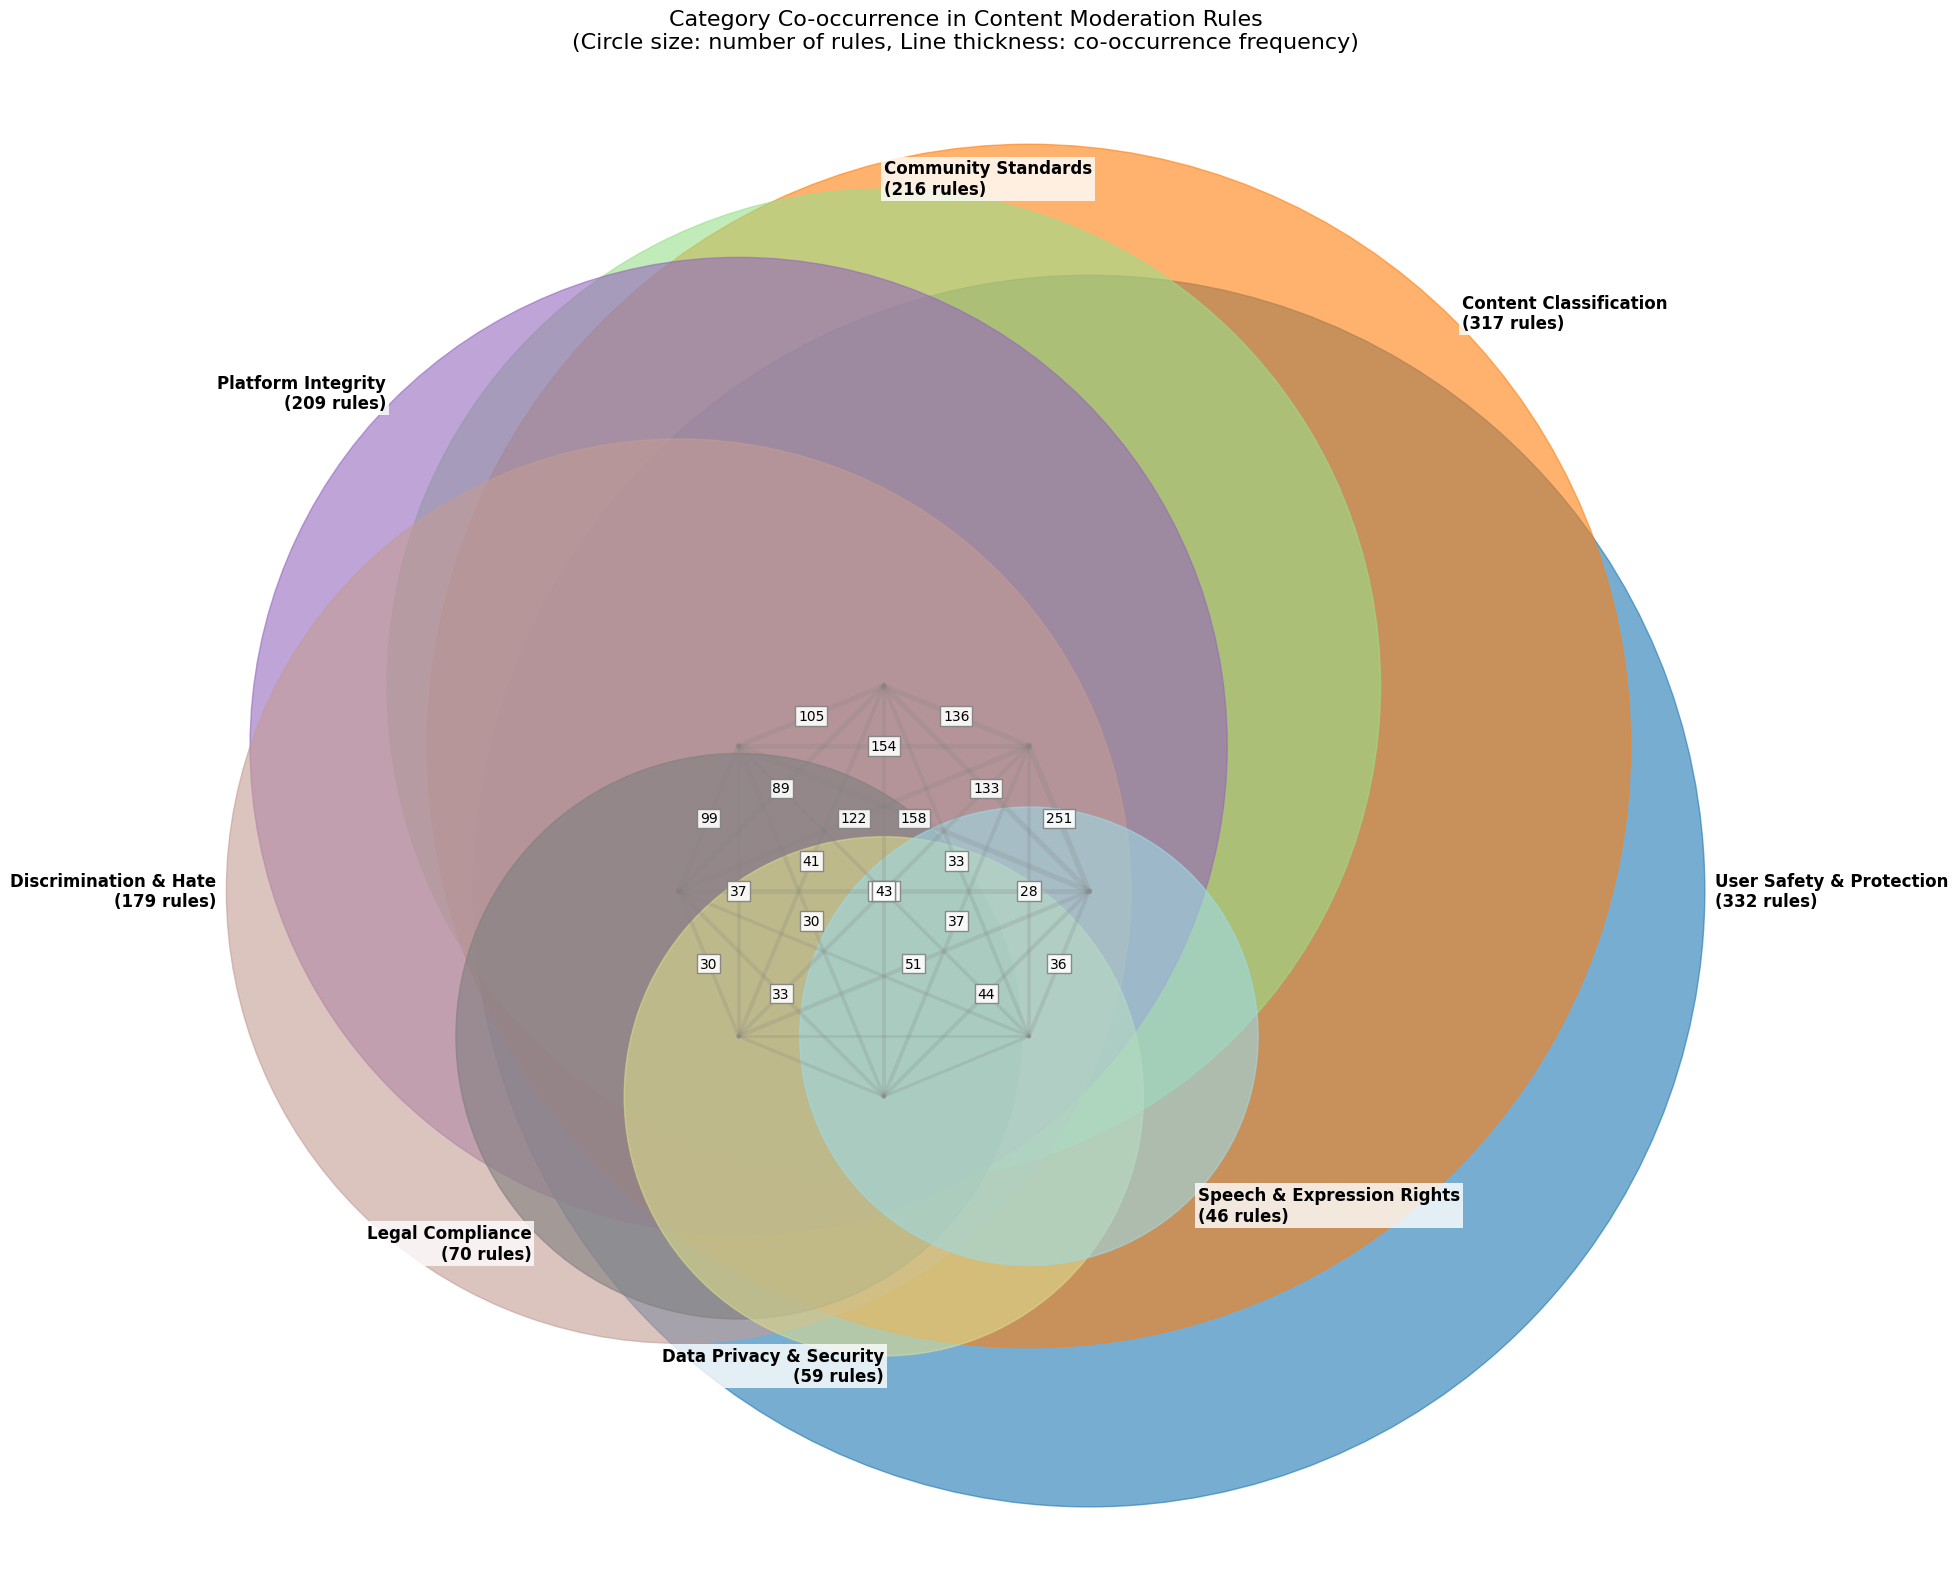

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

def analyze_category_cooccurrence(category_series):
    """
    Analyze how often categories appear together in rules
    """
    # Get all unique categories
    all_categories = set()
    for cats in category_series:
        if isinstance(cats, str):
            categories = [cat.strip() for cat in cats.split(',')]
            all_categories.update(categories)
    
    if 'Other' in all_categories:
        all_categories.remove('Other')
    
    category_counts = {cat: 0 for cat in all_categories}
    cooccurrence = {(cat1, cat2): 0 
                   for cat1, cat2 in combinations(all_categories, 2)}
    
    for cats in category_series:
        if isinstance(cats, str):
            categories = [cat.strip() for cat in cats.split(',')]
            categories = [cat for cat in categories if cat != 'Other']
            
            for cat in categories:
                if cat in category_counts:
                    category_counts[cat] += 1
            
            for cat1, cat2 in combinations(categories, 2):
                if (cat1, cat2) in cooccurrence:
                    cooccurrence[(cat1, cat2)] += 1
                elif (cat2, cat1) in cooccurrence:
                    cooccurrence[(cat2, cat1)] += 1
    
    return category_counts, cooccurrence

def create_improved_visualization(category_series):
    # Get the analysis
    category_counts, cooccurrence = analyze_category_cooccurrence(category_series)
    
    # Print analytics
    print("\nCategory Frequencies:")
    for cat, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{cat}: {count} rules")
    
    print("\nTop Co-occurrences:")
    sorted_cooccurrence = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)
    for (cat1, cat2), count in sorted_cooccurrence[:10]:
        print(f"{cat1} × {cat2}: {count} rules")
    
    # Create visualization with white background
    plt.figure(figsize=(20, 20), facecolor='white')
    
    # Calculate positions in a circle
    categories = list(category_counts.keys())
    n_categories = len(categories)
    angles = np.linspace(0, 2*np.pi, n_categories, endpoint=False)
    
    # Increase radius for better spacing
    radius = 10
    center_x = radius * 1.5
    center_y = radius * 1.5
    
    positions = {}
    
    # Use a color palette that's more distinct
    colors = plt.cm.tab20(np.linspace(0, 1, n_categories))
    
    # Sort categories by count for better visualization
    sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Draw circles and labels
    for i, (category, count) in enumerate(sorted_categories):
        x = center_x + radius * np.cos(angles[i])
        y = center_y + radius * np.sin(angles[i])
        positions[category] = (x, y)
        
        # Adjust size scaling for better visibility
        size = np.sqrt(count) * 30 / np.sqrt(max(category_counts.values()))
        
        circle = plt.Circle((x, y), size,
                          alpha=0.6,
                          color=colors[i])
        plt.gca().add_patch(circle)
        
        # Improve label placement and styling
        label_offset = size + 0.5
        angle = angles[i]
        
        # Adjust text alignment based on position
        ha = 'left' if np.cos(angle) > 0 else 'right'
        
        plt.text(x + np.cos(angle)*label_offset, 
                y + np.sin(angle)*label_offset,
                f"{category}\n({count} rules)",
                ha=ha,
                va='center',
                fontsize=12,
                fontweight='bold',
                bbox=dict(facecolor='white',
                         edgecolor='none',
                         alpha=0.8,
                         pad=2))
    
    # Draw co-occurrence connections
    max_cooccurrence = max(cooccurrence.values())
    min_thickness = 0.5
    max_thickness = 4
    
    for (cat1, cat2), count in cooccurrence.items():
        if count > 0:
            x1, y1 = positions[cat1]
            x2, y2 = positions[cat2]
            
            # Scale thickness logarithmically for better visibility
            thickness = (min_thickness + 
                       (max_thickness - min_thickness) * 
                       np.log1p(count) / np.log1p(max_cooccurrence))
            
            plt.plot([x1, x2], [y1, y2],
                    color='gray',
                    alpha=0.2,
                    linewidth=thickness,
                    zorder=1)  # Put lines behind circles
            
            # Improve co-occurrence count visibility
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            
            if count > max_cooccurrence * 0.1:  # Only show significant connections
                plt.text(mid_x, mid_y,
                        str(count),
                        ha='center',
                        va='center',
                        fontsize=10,
                        bbox=dict(facecolor='white',
                                edgecolor='gray',
                                alpha=0.9,
                                pad=2))
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    
    plt.title('Category Co-occurrence in Content Moderation Rules\n' +
              '(Circle size: number of rules, Line thickness: co-occurrence frequency)',
              pad=20, fontsize=16)
    
    # Add more padding around the plot
    plt.tight_layout(pad=2.0)
    
    return plt

# Use the visualization
plt = create_improved_visualization(df_english["category"])
plt.show()

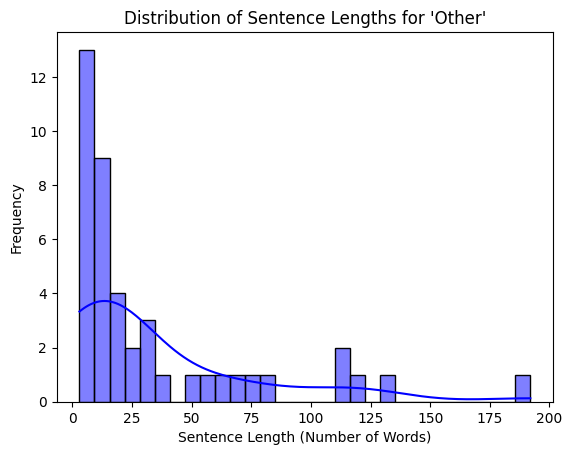

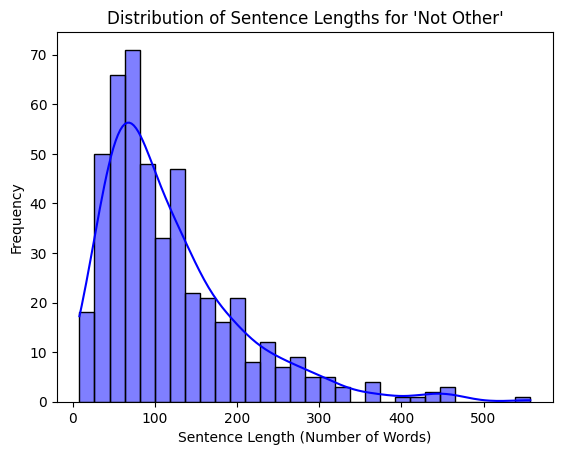

In [14]:

sns.histplot(df_english[df_english['category'] == 'Other']['sentence_length'], bins=30, kde=True, color="blue")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths for 'Other'")
plt.show()

sns.histplot(df_english[df_english['category'] != 'Other']['sentence_length'], bins=30, kde=True, color="blue")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths for 'Not Other'")
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 5))
X = vectorizer.fit_transform(df_english["rules"])

In [16]:
N_CLUSTER = 8

In [17]:
lda = LatentDirichletAllocation(n_components=N_CLUSTER, random_state=42)
lda.fit(X)
doc_topic_distrib = lda.transform(X)
df_english['lda_cluster'] = doc_topic_distrib.argmax(axis=1)

In [18]:
model = AgglomerativeClustering(n_clusters=N_CLUSTER, linkage='ward')
model.fit(X.toarray())
df_english['hierarchical_cluster'] = model.labels_

In [19]:
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=42)
df_english["kmeans_cluster"] = kmeans.fit_predict(X)

In [20]:
def align_clusters(base_labels, target_labels):
    contingency = confusion_matrix(base_labels, target_labels)   
    row_ind, col_ind = linear_sum_assignment(-contingency)
    mapping = {target: base for base, target in zip(row_ind, col_ind)}

    if not isinstance(target_labels, pd.Series):
        target_labels = pd.Series(target_labels)
    
    aligned_labels = target_labels.map(mapping)
    return aligned_labels

In [21]:
df_english["lda_cluster_aligned"] = align_clusters(df_english["kmeans_cluster"], df_english["lda_cluster"])
df_english["hierarchical_cluster_aligned"] = align_clusters(df_english["kmeans_cluster"], df_english["hierarchical_cluster"])

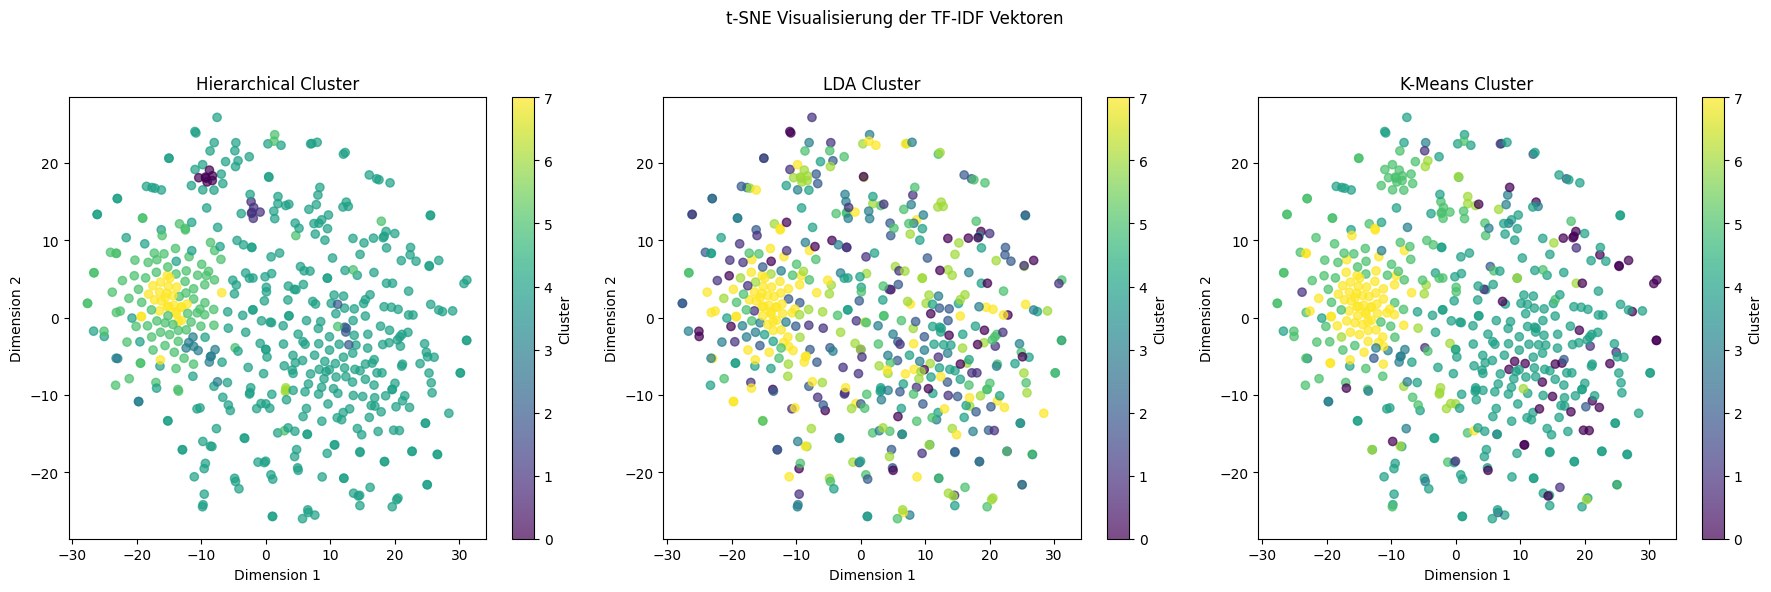

In [22]:
def plot_tsne_clusters(X, df, cluster_columns, titles, random_state=42):

    tsne = TSNE(n_components=2, random_state=random_state)
    X_embedded = tsne.fit_transform(X.toarray())
    
    fig, axes = plt.subplots(1, len(cluster_columns), figsize=(6 * len(cluster_columns), 6))
    
    if len(cluster_columns) == 1:
        axes = [axes]
    
    for ax, col, title in zip(axes, cluster_columns, titles):
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], 
                             c=df[col], cmap="viridis", alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label("Cluster")
    
    plt.suptitle("t-SNE Visualisierung der TF-IDF Vektoren")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

cluster_columns = ["hierarchical_cluster_aligned", "lda_cluster_aligned", "kmeans_cluster"]
titles = ["Hierarchical Cluster", "LDA Cluster", "K-Means Cluster"]
plot_tsne_clusters(X, df_english, cluster_columns, titles)



In [23]:
# get categories from cluster labels
def get_cluster_categories(df, cluster_column):
    cluster_categories = df.groupby(cluster_column)["category"].apply(lambda x: x.value_counts().index[0])
    return cluster_categories

cluster_categories = get_cluster_categories(df_english, "hierarchical_cluster")
cluster_categories

hierarchical_cluster
0                                                Other
1     User Safety & Protection, Content Classification
2    User Safety & Protection, Content Classificati...
3    User Safety & Protection, Discrimination & Hat...
4    User Safety & Protection, Discrimination & Hat...
5    User Safety & Protection, Discrimination & Hat...
6     User Safety & Protection, Content Classification
7    User Safety & Protection, Discrimination & Hat...
Name: category, dtype: object

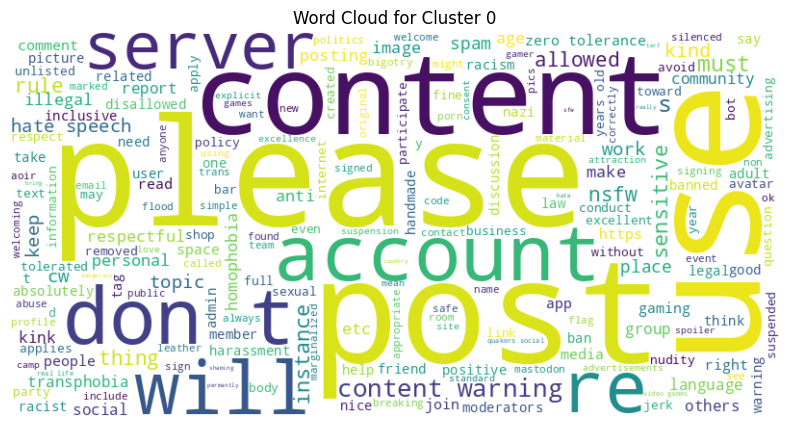

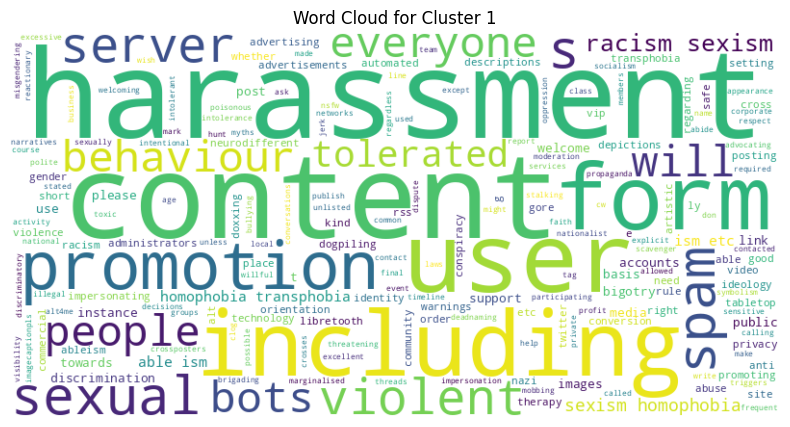

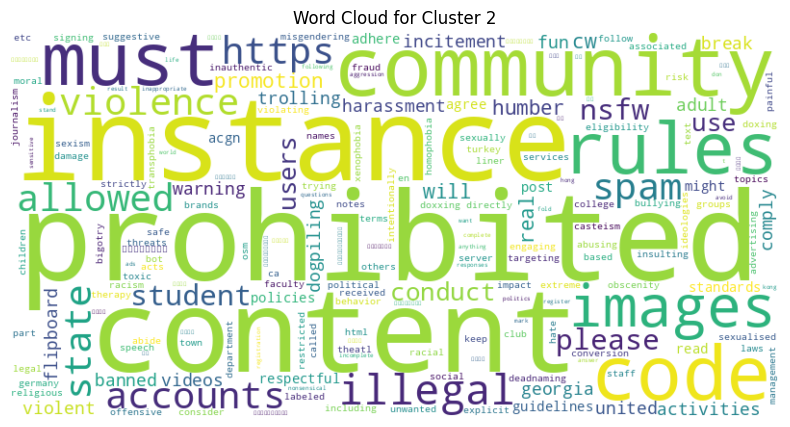

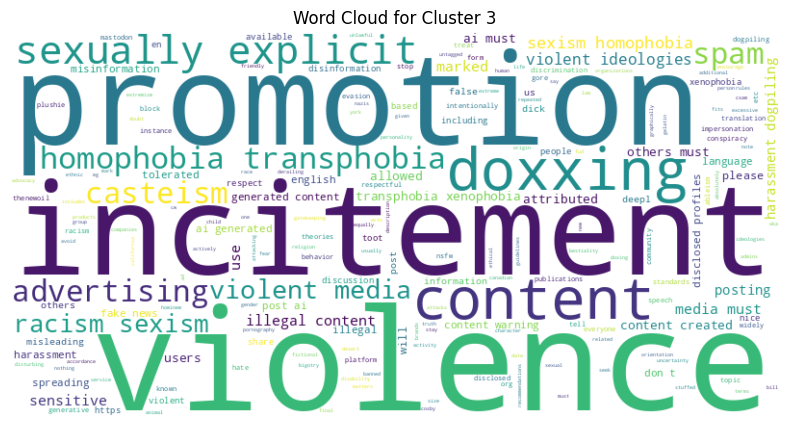

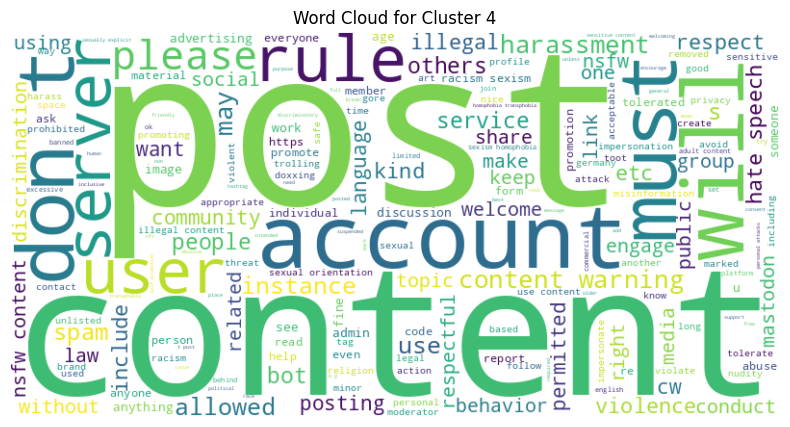

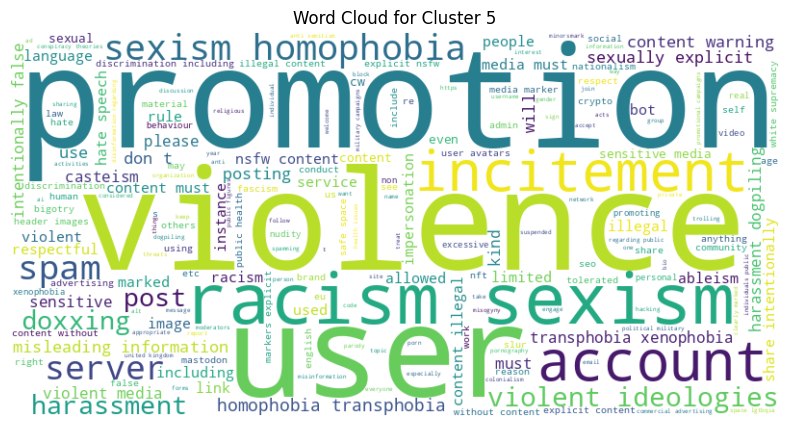

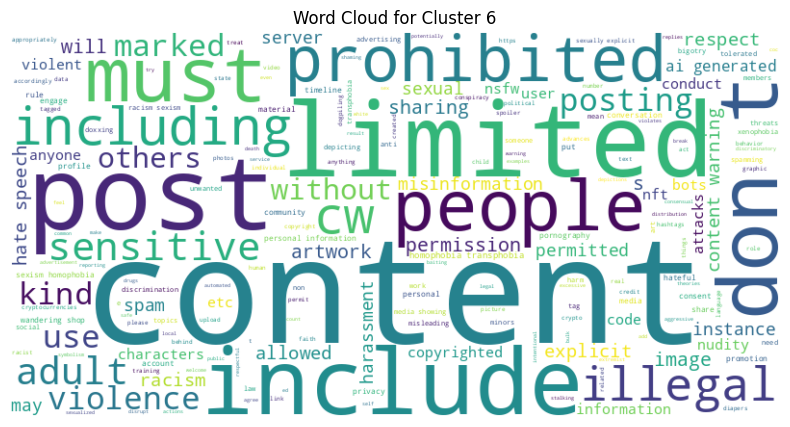

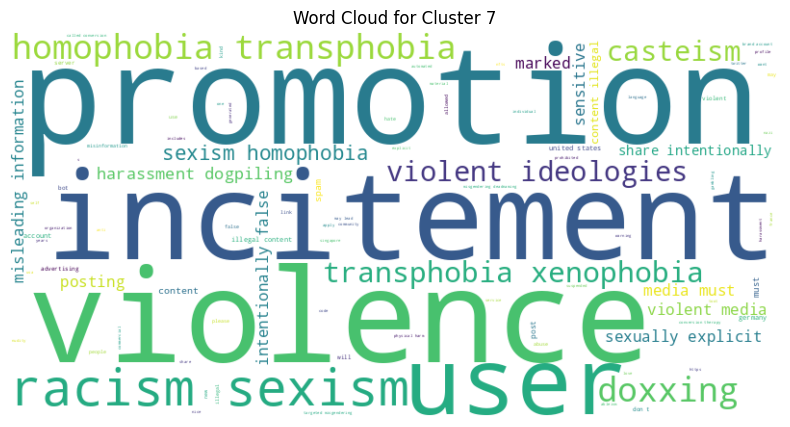

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# Create word clouds for each cluster
for cluster_num in range(N_CLUSTER):
    cluster_rules = df_english[df_english["kmeans_cluster"] == cluster_num]["rules"]
    
    cluster_words = []
    for rule in cluster_rules:
        words = re.findall(r"\w+", rule.lower())  # Tokenize words
        cluster_words.extend(words)

    # Convert word frequencies to a string format
    text = " ".join(cluster_words)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide axes
    plt.title(f"Word Cloud for Cluster {cluster_num}")
    plt.show()
